# Maximum Likelihood Estimation of Custom Models in Python with StatsModels
based on http://austinrochford.com/posts/2015-03-03-mle-python-statsmodels.html

## Distribution
Uses custom [zero-inflated Poisson model](https://en.wikipedia.org/wiki/Zero-inflated_model).

$$
P(X = 0) = \pi + (1 - \pi) e^ {-\lambda}
$$
$$
P(X = x) = (1 - \pi) e ^{-\lambda} \frac{\lambda^{x}}{x!},
$$
for $x > 0$.

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

# list available fonts: [f.name for f in matplotlib.font_manager.fontManager.ttflist]
# fix warning: /opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
matplotlib.rc('font', family='DejaVu Sans')

pi_default = 0.3
lambda_default = 2.0

In [2]:
def zip_pmf(x, pi=pi_default, lambda_=lambda_default):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

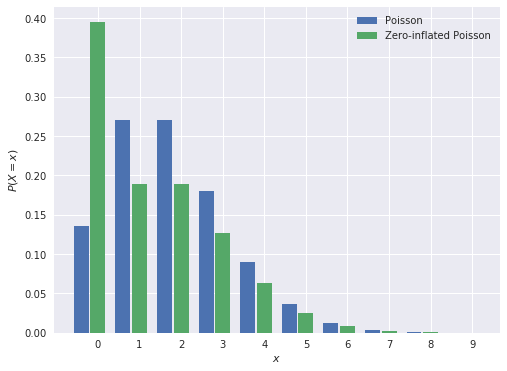

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

xs = np.arange(0, 10);

palette = sns.color_palette()

ax.bar(2.5 * xs, stats.poisson.pmf(xs, lambda_default), width=0.9, color=palette[0], label='Poisson');
ax.bar(2.5 * xs + 1, zip_pmf(xs), width=0.9, color=palette[1], label='Zero-inflated Poisson');

ax.set_xticks(2.5 * xs + 1);
ax.set_xticklabels(xs);
ax.set_xlabel('$x$');

ax.set_ylabel('$P(X = x)$');

ax.legend();
plt.show()

## Maximum likelihood estimation

In [4]:
N = 1000 # observations
inflated_zero = stats.bernoulli.rvs(pi_default, size=N)
x = (1 - inflated_zero) * stats.poisson.rvs(lambda_default, size=N)

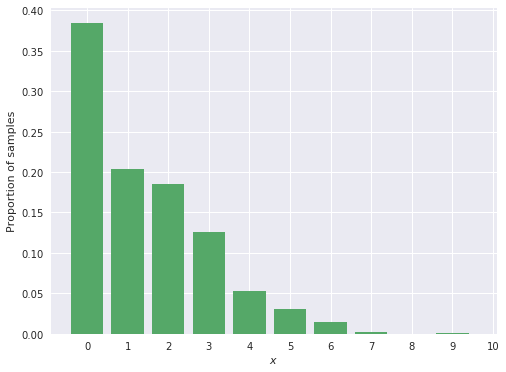

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, width=0.8, bins=np.arange(x.max() + 1), normed=True, color=palette[1]);

ax.set_xticks(np.arange(x.max() + 1) + 0.4);
ax.set_xticklabels(np.arange(x.max() + 1));
ax.set_xlabel('$x$');

ax.set_ylabel('Proportion of samples');

plt.show()

### Estimate parameters $\pi$ and $\lambda$

In [6]:
class ZeroInflatedPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super().__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi = params[0]
        lambda_ = params[1]

        return -np.log(zip_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            lambda_start = self.endog.mean()
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros, lambda_start])
            
        return super().fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun, **kwds)

In [7]:
model = ZeroInflatedPoisson(x)
results = model.fit()

pi_mle, lambda_mle = results.params

pi_mle, lambda_mle

Optimization terminated successfully.
         Current function value: 1.614398
         Iterations: 37
         Function evaluations: 72


(0.28806706431365048, 2.0044140652839486)

### Bootstrap resampling to estimate the variation in our parameter estimates

In [8]:
boot_mean, boot_std, boot_samples = results.bootstrap(nrep=500, store=True)
boot_pis = boot_samples[:, 0]
boot_lambdas = boot_samples[:, 1]


<class '__main__.ZeroInflatedPoisson'>


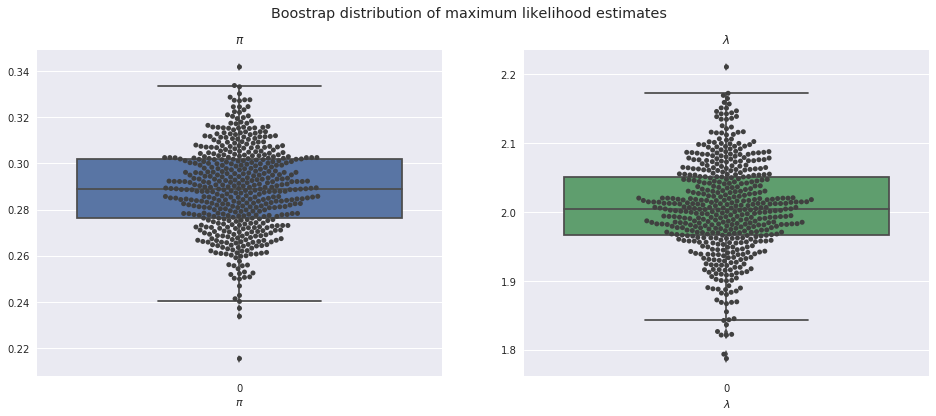

In [12]:
fig, (pi_ax, lambda_ax) = plt.subplots(ncols=2, figsize=(16, 6))

pi_ax.set_title('$\pi$')
sns.boxplot(data=boot_pis, ax=pi_ax, color=palette[0]);
sns.swarmplot(data=boot_pis, ax=pi_ax, color='0.25');

lambda_ax.set_title('$\lambda$') 
sns.boxplot(data=boot_lambdas, ax=lambda_ax, color=palette[1]);
sns.swarmplot(data=boot_lambdas, ax=lambda_ax, color='0.25');

fig.suptitle('Boostrap distribution of maximum likelihood estimates');
plt.show()